# Determine DVH when given dicom dose and structure files
Copyright (C) 2016-2017 Simon Biggs

This program is free software: you can redistribute it and/or modify it under the terms of the GNU Affero General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License along with this program. If not, see http://www.gnu.org/licenses/.

In [1]:
import dicom
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import path

from scipy.interpolate import interp1d

%matplotlib inline

In [2]:
dcm_struct = dicom.read_file("structures.dcm", force=True)

dcm1 = dicom.read_file("PH1_dose.DCM", force=True)
dcm2 = dicom.read_file("PH2_dose.DCM", force=True)

In [3]:
def load_dose_from_dicom(dcm):
    pixels = np.transpose(
        dcm.pixel_array, (1, 2, 0))
    dose = pixels * dcm.DoseGridScaling
    
    return dose

def load_xyz_from_dicom(dcm):
    resolution = np.array(
        dcm.PixelSpacing).astype(float)
    dx = resolution[0]
    
    x = (
        dcm.ImagePositionPatient[0] + 
        np.arange(0, dcm.Columns * dx, dx))
    
    dy = resolution[1]
    y = (
        dcm.ImagePositionPatient[1] + 
        np.arange(0, dcm.Rows * dy, dy))
    
    z = (
        np.array(dcm.GridFrameOffsetVector) + 
        dcm.ImagePositionPatient[2])
    
    return x, y, z

In [4]:
dose1 = load_dose_from_dicom(dcm1)
x1, y1, z1 = load_xyz_from_dicom(dcm1)

dose2 = load_dose_from_dicom(dcm2)
x2, y2, z2 = load_xyz_from_dicom(dcm2)

assert np.all(x1 == x2)
assert np.all(y1 == y2)
assert np.all(z1 == z2)
x = x1
y = y1
z = z1

dose_ph1and2 = dose1*23 + dose2*7

In [6]:
def pull_structure_by_number(number):
    structure_names = [
        item.ROIName for item in dcm_struct.StructureSetROISequence]
    
    contours_by_slice_raw = [
        item.ContourData for item in dcm_struct.ROIContourSequence[number].ContourSequence]
    x = [np.array(item[0::3]) for item in contours_by_slice_raw]
    y = [np.array(item[1::3]) for item in contours_by_slice_raw]
    z = [np.array(item[2::3]) for item in contours_by_slice_raw]
    
    print("Loaded {}".format(structure_names[number]))
    return x, y, z

def pull_structure(string):
    structure_names = np.array(
        [item.ROIName for item in dcm_struct.StructureSetROISequence])
    reference = structure_names == string
    if np.all(reference == False):
        raise Exception("Structure not found (case sensitive)")
        
    index = int(np.where(reference)[0])    
    x, y, z = pull_structure_by_number(index)

    return x, y, z

In [29]:
def get_index(z_list, z_val):
    indices = np.array([item[0] for item in z_list])
    # This will error if more than one contour exists on a given slice
    index = int(np.where(indices == z_val)[0])
    # Multiple contour sets per slice not yet implemented
    
    return index

In [30]:
xx, yy = np.meshgrid(x, y)
points = np.swapaxes(np.vstack([xx.ravel(), yy.ravel()]), 0, 1)

In [31]:
def find_dose_within_structure(structure):
    x_structure, y_structure, z_structure = pull_structure(structure)
    structure_z_values = np.array([item[0] for item in z_structure])
    
    structure_dose_values = np.array([])

    for z_val in structure_z_values:
        structure_index = get_index(z_structure, z_val)
        dose_index = int(np.where(z == z_val)[0])

        assert z_structure[structure_index][0] == z[dose_index]

        structure_polygon = path.Path([
                (x_structure[structure_index][i], y_structure[structure_index][i]) 
                for i in range(len(x_structure[structure_index]))
            ])
        mask = structure_polygon.contains_points(points).reshape(len(y), len(x))
        masked_dose = dose_ph1and2[:, :, dose_index]
        structure_dose_values = np.append(structure_dose_values, masked_dose[mask])
    
    return structure_dose_values

In [32]:
def create_dvh(structure):
    structure_dose_values = find_dose_within_structure(structure)
    hist = np.histogram(structure_dose_values, 100)
    freq = hist[0]
    bin_edge = hist[1]
    bin_mid = (bin_edge[1::] + bin_edge[:-1:])/2

    cumulative = np.cumsum(freq[::-1])
    cumulative = cumulative[::-1]
    bin_mid = np.append([0], bin_mid)

    cumulative = np.append(cumulative[0], cumulative)
    percent_cumulative = cumulative / cumulative[0] * 100

    plt.plot(bin_mid, percent_cumulative, label=structure)
    plt.title('DVH')
    plt.xlabel('Total Delivered Dose (Gy)')
    plt.ylabel('Relative Volume (%)')    
    

In [33]:
structure_names = [item.ROIName for item in dcm_struct.StructureSetROISequence]
structure_names

['patient',
 'RT HOF',
 'LT HOF',
 'BLADDER',
 'RECTUM',
 'bowel',
 'ctv68',
 'ctv46 lt node',
 'rt node ctv 46',
 'ctv60',
 'PTV68',
 'PTV46',
 'PTV60',
 'eval46',
 'Couch Outer',
 'Couch Parts',
 'Couch Foam',
 'ptvnew46']

Loaded RECTUM
Loaded PTV60
Loaded PTV68
Loaded patient


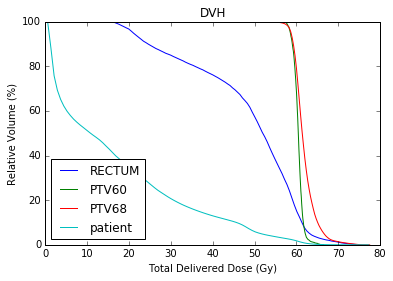

In [36]:
create_dvh('RECTUM')
create_dvh('PTV60')
# create_dvh('PTV46') # Multiple contours on single slice not yet implimented
create_dvh('PTV68')
# create_dvh('ptvnew46') # Multiple contours on single slice not yet implimented
create_dvh('patient')

plt.legend(loc=0)